## Viscous Inverse Design
This notebook demonstrates the use of gradients from viiflow for fully viscous inverse design.
It defines a target pressure distribution from one airfoil and, coming from another airfoil, tries to find the shape necessary to arrive at this target pressure.
It uses virtual displacements, which do not necessitate the recalculation of the panel operator.
Instead, it uses the same model used for the effect of boundary layer thickness onto the flow for modification of the airfoil shape.

The heart of this notebook is a Gauss-Newton iteration which solves for these virtual displacements.
Instead of trying to solve the pressure distribution exactly, the iteration sovles a least-squares problem that joins the pressure difference with regularizing terms.
Fully viscous inverse design is not a straightforward problem. There are several ways an optimizer may *cheat*, for example

* The velocity is defined by the inviscid solution of the airfoil shape plus boundary layer thickness. An optimizer can therefore choose to reduce the thickness of the airfoil if for some reason a thick boundary layer leads to the target velocity distribution.
* Kinks in the desired velocity are, in the case below, due to laminar-turbulent transition. However, an optimizer can choose to model this kink by an actual kink in the airfoil.

To alleviate this, the pressure error is appended by a regularizing term that penalizes non-smooth displacements - simply by adding $ \frac{\mathrm{d}^2}{\mathrm{d}^2 s} \delta_{virtual}(s) $ at every point along the airfoil surface coordinate $s$ to the Least-Squares problem.

The parameters chosen to increrase/decrease the penalties were chosen ad-hoc by trial and error.
In addition, the nodes very close to the stagnation point are not modified.

In addition, the residual $r$ of the viiflow solver itself is added to the Least-Squares problem and scaled such that at convergence its error is sufficiently low.
Every iteration then performs for dispalcements $y$ and the viiflow variables $x$
$$ 
y^{k+1} = y^k - \lambda {\Delta y}^k\\
x^{k+1} = x^k - \lambda {\Delta x}^k\\
{\Delta y}^k, {\Delta x}^k = \min_{\Delta y,\Delta x} \| F(y^k,x^k) - \frac{\partial F}{\partial y}(y^k,x^k) \Delta y - \frac{\partial F}{\partial x}(y^k,x^k) \Delta x\|^2\\
\|F(y,x)\|^2 = \gamma_{cp}^2\|ue(y)-ue_{target}\|^2 + \gamma_y^2\| \frac{\mathrm{d}^2}{\mathrm{d}^2 s} y \|^2 + \gamma_r^2 \|r(y,x)\|^2
$$
This may seem like a large problem, but the effort for solving the overdetermined least-squares problem grows largely with the degrees of freedom, not the amount of equations.

Below, this procedure is used to morph the S805 airfoil into the S825 airfoil. Even with the regularizing terms, little dips that enforce the laminar-turbulent transition can still be seen when zooming in.

While this solves for an airfoil shape of a specified pressure distribution, it is probably not a very smart idea to use this for actual design. A better idea is to use first an inviscid inverse design method, e.g. conformal mapping [1, 2], and remove the discrepancies using a fully viscid iteration.
The benefit of this Gauss-Newton approach is how straightforward additional constraints can be included, e.g. only fit the suction side from .1c onwards or fit multiple target distributions at multiple angles of attack.

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [21]:
# Analysis Settings
RE = 1e6
ncrit =9
Mach = 0.0
alpha = 2.0

N = 200

# Read Airfoils
BASE = vft.repanel(vft.read_selig("S805.dat"),N,KAPFAC=2)
TARGET = vft.repanel(vft.read_selig("S825.dat"),N,KAPFAC=2)
# Solve target for our target cp (or more precisely edge velocity)
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=alpha)

# Internal iterations
s.Itermax = 100

# Set-up and initialize based on inviscid panel solution
[p,bl,x] = vf.init([TARGET],s)
res = None
grad = None


# Solve aerodynamic problem of target airfoil
vf.iter(x,bl,p,s,None,None)
XT0 = p.foils[0].X[0,:].copy()
UT = p.gamma_viscid[0:p.foils[0].N].copy()

# Set-up and initialize based on inviscid panel solution
[p,bl,x0] = vf.init([BASE],s)
res = None
grad = None

# Solve aerodynamic problem of current airfoil and save for later plotting
[x0,_,res,grad,_] = vf.iter(x0,bl,p,s,None,None)
XC0 = p.foils[0].X[0,:].copy()
UC = p.gamma_viscid[0:p.foils[0].N].copy()

# To interpolate from one grid to the next, suction and pressure side must have unique grid points
# That is why below a grid is created where the pressure side is appended with *-1 at the nose
XT = XT0.copy()
XC = XC0.copy()
XT[np.argmin(XT0)+1::] = 2*XT0[np.argmin(XT0)]-XT0[np.argmin(XT0)+1::]
XC[np.argmin(XC0)+1::] = 2*XC0[np.argmin(XC0)]-XC0[np.argmin(XC0)+1::]

# Interpolate target pressure onto current airfoil grid
UT = np.interp(-XC.flatten(),-XT.flatten(),np.asarray(UT[:,0]).flatten())

Iteration 11, |res| 0.000090, lam 1.000000
Iteration 12, |res| 0.000012, lam 1.000000


In [22]:
# Weighting factors for Gauss-Newton
facx = 500 # Penalty for smooth dioscplacement
fac_err = 5 #Weighting of cp error w.r.t. above penalties
fac_res = 1e4
s.Gradients = True

NAERO = x.shape[0]
NVD = len(XC)

# Set-up and initialize based on inviscid panel solution
[p,bl,x0] = vf.init([BASE],s)
res = None
grad = None

# Solve aerodynamic problem to convergence
[x,_,_,_,_] = vf.iter(x0,bl,p,s,None,None)
fprev = np.inf
# Find ST and do not change near there
II = np.logical_and(np.fabs(XT-XT[bl[0].sti])>0.001,p.foils[0].X[0,:].ravel()>np.amin(p.foils[0].X[0,:].ravel()))
II[0]=False
II[NVD-1]=False
iter = 0
lam = 1.0
y = np.zeros(NVD)
while True:
    iter+=1

    # Solve Aerodynamic problem
    s.Itermax = 0
    s.Silent = True
    [_,_,res,grad,gradients] = vf.iter(x,bl,p,s,None,None,y)

    # Residual 
    RESy = fac_err*(p.gamma_viscid[0:p.foils[0].N].A1-UT)
    dRESydy = fac_err*gradients.partial.gam_vd[0:NVD,:]
    dRESydx = fac_err*gradients.partial.gam_x[0:NVD,:]
    
    # Penalty for thick boundary layer
    #REGdelta = bl[0].bl_fl.nodes.delta*facx
    #dREGdeltady = gradients.total.delta_vd[0:NVD,:]*facx
    
    # Penalty for smooth displacement
    difforder = 2
    REGdelta = np.diff(y,difforder)*facx
    dREGdeltady = np.diff(np.eye(NVD),difforder,0)*facx
    dREGdeltadx = np.zeros((len(REGdelta),len(x)))
    
    # Gauss-Newton step from all terms
    F = np.r_[RESy,REGdelta,res*fac_res]
    fcurr = np.sqrt(F.T@F)
    
    y0 = y
    fprev = fcurr
    # Find ST and do not change near there
    II = np.logical_and(np.fabs(XT-XT[bl[0].sti])>0.001,p.foils[0].X[0,:].ravel()>np.amin(p.foils[0].X[0,:].ravel()))
    II[0]=False
    II[NVD-1]=False
    
    dFdy = np.r_[dRESydy,dREGdeltady,gradients.partial.res_vd*fac_res]
    dFdx = np.r_[dRESydx,dREGdeltadx,grad*fac_res]
    dF = np.c_[dFdy[:,II],dFdx]
    dX = -np.linalg.lstsq(dF,F,rcond=None)[0]
    dy = dX[0:np.sum(II)]
    dx = dX[np.sum(II)::]
    lam = 1
    
    # Print
    resaero = np.sqrt(np.matmul(res,res.T))

    


    # Ad-hoc Damping
    for k in range(len(dy)):
        lam = np.fmin(lam,0.003/abs(dy[k])) # Do not move virtual displacement more than 1mm
    for k in range(len(x)):
        lam = np.fmin(lam,.2/(abs(dx[k]/x[k])))
        
    print("iter %u res p:%f resaero: %f dvd:%f lam:%f"%(iter, np.sqrt(np.matmul(F,F.T)), \
                resaero,np.sqrt(np.matmul(dy,dy.T)),lam))
        
    if np.sqrt(np.matmul(dy,dy.T))<1e-4 and resaero<1e-4:
        print("Converged")
        break
        
    if iter>100:
        print("Not Converged (iteration)")
        break
        
    j =0
    for k in np.argwhere(II):
        y[k] += lam*dy[j]
        j+=1
    x += lam*dx


Iteration 11, |res| 0.000001, lam 1.000000
iter 1 res p:11.577981 resaero: 0.000001 dvd:0.203364 lam:0.082208
iter 2 res p:12.242767 resaero: 0.000604 dvd:0.186259 lam:0.087117
iter 3 res p:13.764105 resaero: 0.000972 dvd:0.172358 lam:0.089896
iter 4 res p:15.959540 resaero: 0.001324 dvd:0.156115 lam:0.062213
iter 5 res p:71.926046 resaero: 0.007145 dvd:0.130364 lam:0.077548
iter 6 res p:68.975690 resaero: 0.006854 dvd:0.107978 lam:0.079449
iter 7 res p:65.172692 resaero: 0.006477 dvd:0.096770 lam:0.123907
iter 8 res p:62.255992 resaero: 0.006190 dvd:0.082984 lam:0.202047
iter 9 res p:61.330019 resaero: 0.006106 dvd:0.086396 lam:0.113290
iter 10 res p:76.589723 resaero: 0.007641 dvd:0.076817 lam:0.172184
iter 11 res p:70.039507 resaero: 0.006988 dvd:0.068556 lam:0.129219
iter 12 res p:141.566505 resaero: 0.014151 dvd:0.069234 lam:0.197901
iter 13 res p:121.521239 resaero: 0.012147 dvd:0.062641 lam:0.172071
iter 14 res p:109.742756 resaero: 0.010969 dvd:0.052044 lam:0.207561
iter 15 res

(-0.050014908717028954, 1.0500007099389062)

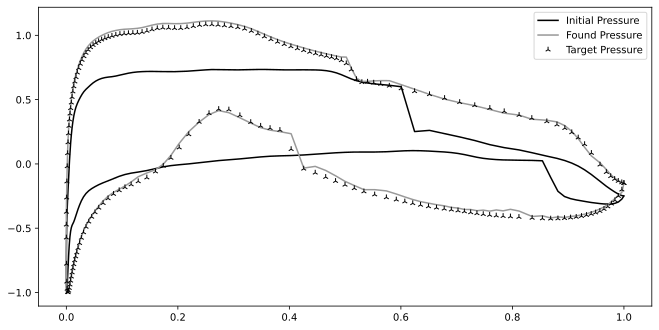

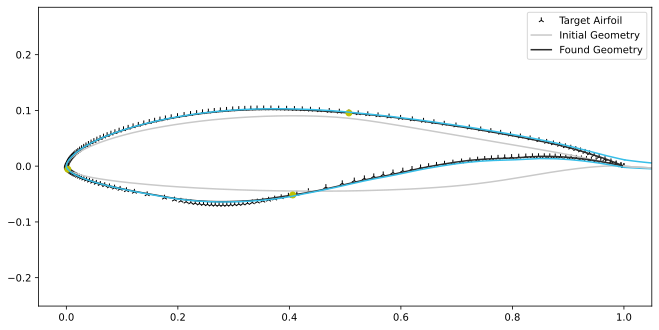

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = [11, 5.5]
fig,ax = plt.subplots(1,1)
ax.plot(p.foils[0].X[0,:],np.power(UC,2)-1,'-k')
ax.plot(p.foils[0].X[0,:],np.power(p.gamma_viscid[0:p.foils[0].N].A1,2)-1,'-',color=(0.6,0.6,0.6))
ax.plot(p.foils[0].X[0,:],np.power(UT,2)-1,'2k')
ax.legend(['Initial Pressure','Found Pressure','Target Pressure'])
xlim = ax.get_xlim()

fig,ax = plt.subplots(1,1)
lines = None
ax.plot(TARGET[0,:],TARGET[1,:],'2k')
lines = vfp.plot_geometry(ax,p,bl,lines)
ax.legend(['Target Airfoil','Initial Geometry','Found Geometry'])
ax.set_xlim(xlim)

[1] Selig, Michael S., and Mark D. Maughmer. *Generalized multipoint inverse airfoil design.* AIAA journal 30.11 (1992): 2618-2625.

[2] Drela, Mark. *XFOIL: An analysis and design system for low Reynolds number airfoils.* Low Reynolds number aerodynamics. Springer, Berlin, Heidelberg, 1989. 1-12.